# Model E

This is a script showing results of **model E** in the ablation studies. The model is built using the following configuration:

- **Backbone:** GATv2
- **Graph type:** Homogeneous
- **Loss function:** Binary-Cross Entropy with Logits Loss
- **Embeddings used:** average
- **Keyword popularity used:** No

*This model introduces a baseline loss function Binary-Cross Entropy with Logits loss to compare against Bayesian Personalized Ranking on graph attention network backbone.*

## **Setting up environment**

---



### Loading libraries

In [1]:
import os
import sys

sys.path.insert(0, os.path.abspath(".."))

import torch
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from typing import Optional

from torch import Tensor
from torch.nn import ModuleList
import torch.nn.functional as F
from torch.optim import Optimizer
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.nn.conv import GATv2Conv
from torch.optim.lr_scheduler import LRScheduler

from util.torch_geometric import get_results
from util.homogeneous.dataset import DatasetEuCoHM
from util.homogeneous.model import ModelEuCoHM
from util.homogeneous.train import (
    train,
    test,
    evaluate
)

### Global variables

In [2]:
# Model name
model_name = 'E'
# Dataset save filepath
dataset_save_filepath = '../data/dataset_homogeneous_base.pkl'
# Device name
device = 'cpu'

# Model configuration
model_config = dict(
    hidden_channels=64,
    learning_rate=1e-3,
    num_layers=4,
    num_epochs=50,
    num_recommendations=10
)
# Set seaborn theme
sns.set_theme(style="whitegrid", palette="pastel")

## Loading dataset

---


In [3]:
# Add the object as a safe global to shut down warning
torch.serialization.add_safe_globals([DatasetEuCoHM])
# Open the dataset file and save it to variable
with open(dataset_save_filepath, 'rb') as file:
    dataset: DatasetEuCoHM = pickle.load(file)

data = dataset.data
author_id_map = dataset.author_id_map
author_node_id_map = dataset.author_node_id_map

/home/eucollab/eutopia-colllaboration/ecr-recommender/.venv/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.loa

## Model training


---



### Model definition

In [4]:
class ModelEuCoE(ModelEuCoHM):
    def __init__(self,
                 input_channels: int,
                 hidden_channels: int,
                 num_layers: int,
                 num_recommendations: int,
                 author_node_id_map: dict,
                 author_id_map: dict,
                 device: str = 'cpu'):
        super().__init__(
            input_channels=input_channels,
            hidden_channels=hidden_channels,
            num_layers=num_layers,
            num_recommendations=num_recommendations,
            author_node_id_map=author_node_id_map,
            author_id_map=author_id_map,
            device=device
        )

    
    def recommendation_loss(self,
                            x: Tensor,
                            edge_index: Adj,
                            pos_edge_rank: Tensor,
                            neg_edge_rank: Tensor,
                            edge_weight: Optional[Tensor] = None,
                            node_id: Optional[Tensor] = None) -> Tensor:

        # Construct labels
        pos_labels = pos_edge_rank.new_ones(pos_edge_rank.size(0))
        neg_labels = neg_edge_rank.new_zeros(neg_edge_rank.size(0))

        # Concatenate predictions and labels
        all_preds = torch.cat([pos_edge_rank, neg_edge_rank], dim=0)
        all_labels = torch.cat([pos_labels, neg_labels], dim=0)

        # Compute BCE loss
        bce_loss = F.binary_cross_entropy_with_logits(all_preds, all_labels)

        return bce_loss

### Training the model

In [5]:
# Initialize the model
model = ModelEuCoE(
    input_channels=data.num_features,
    hidden_channels=model_config['hidden_channels'],
    num_recommendations=model_config['num_recommendations'],
    num_layers=model_config['num_layers'],
    author_node_id_map=author_node_id_map,
    author_id_map=author_id_map
).to(device)

# Transfer to device
data = data.to(device)

# Initialize the optimizer
optimizer: Optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=model_config['learning_rate']
)

# Initialize the scheduler
scheduler: LRScheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    mode='min',
    factor=0.5,
    patience=10
)

In [6]:
results: list = list()
for epoch in range(1, model_config['num_epochs'] + 1):
    # ------ Train
    train_loss: float = train(
        model=model,
        data=data,
        optimizer=optimizer
    )
    # ------ Test
    test_loss: float = test(
        model=model,
        data=data
    )
    scheduler.step(test_loss)
    # ------ Evaluate
    evaluation_results: dict = evaluate(
        k=model_config['num_recommendations'],
        model=model,
        data=data
    )

    # Save results
    epoch_result = get_results(
        epoch=epoch,
        train_loss=train_loss,
        test_loss=test_loss,
        evaluation_results=evaluation_results
    )
    results.append(epoch_result)

Epoch 1, train loss: 0.5602, test loss: 0.6976, precision@k: 0.0409, recall@k: 0.1181, MAP@k: 0.0626, MRR@k: 0.1089, NDCG@k: 0.0909, HitRate@k: 0.2173
Epoch 2, train loss: 0.4865, test loss: 0.6098, precision@k: 0.0454, recall@k: 0.1298, MAP@k: 0.0690, MRR@k: 0.1171, NDCG@k: 0.0998, HitRate@k: 0.2357
Epoch 3, train loss: 0.4590, test loss: 0.5663, precision@k: 0.0491, recall@k: 0.1394, MAP@k: 0.0737, MRR@k: 0.1237, NDCG@k: 0.1066, HitRate@k: 0.2515
Epoch 4, train loss: 0.4407, test loss: 0.5400, precision@k: 0.0506, recall@k: 0.1441, MAP@k: 0.0765, MRR@k: 0.1287, NDCG@k: 0.1105, HitRate@k: 0.2597
Epoch 5, train loss: 0.4309, test loss: 0.5215, precision@k: 0.0524, recall@k: 0.1490, MAP@k: 0.0798, MRR@k: 0.1344, NDCG@k: 0.1149, HitRate@k: 0.2671
Epoch 6, train loss: 0.4253, test loss: 0.5067, precision@k: 0.0536, recall@k: 0.1517, MAP@k: 0.0818, MRR@k: 0.1383, NDCG@k: 0.1177, HitRate@k: 0.2719
Epoch 7, train loss: 0.4183, test loss: 0.4944, precision@k: 0.0550, recall@k: 0.1554, MAP@k: 

### Model evaluation

In [7]:
results_df = pd.DataFrame(results)
results_df.to_csv(f'../results/results_Model{model_name}.csv', index=False)

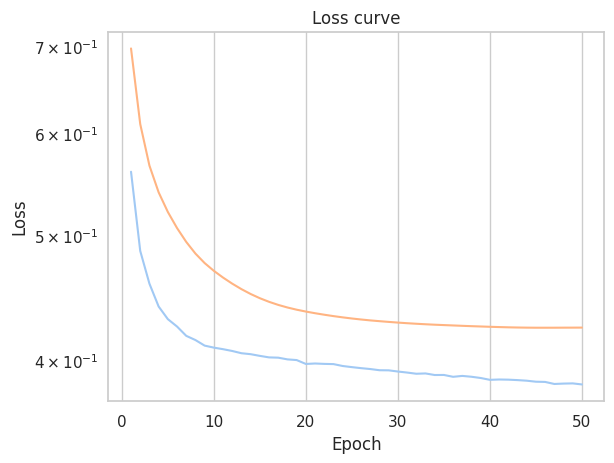

In [8]:
# Generate loss curve
# Train loss
sns.lineplot(data=results_df, x='Epoch', y='Train Loss')
# Test loss
sns.lineplot(data=results_df, x='Epoch', y='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss curve')
plt.yscale('log')
plt.show()

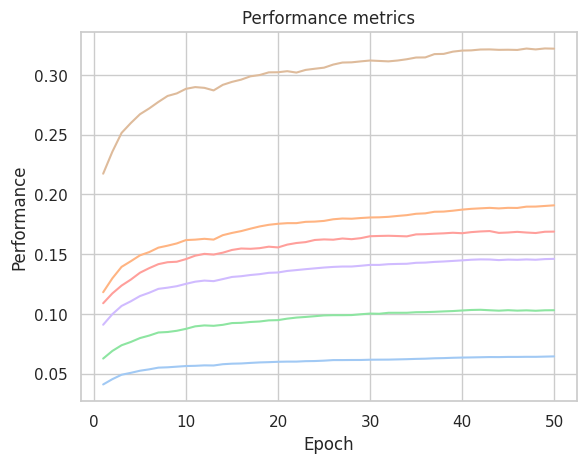

In [9]:
# Generate evaluation metrics plot
sns.lineplot(data=results_df, x='Epoch', y='Precision@k')
sns.lineplot(data=results_df, x='Epoch', y='Recall@k')
sns.lineplot(data=results_df, x='Epoch', y='MAP@k')
sns.lineplot(data=results_df, x='Epoch', y='MRR@k')
sns.lineplot(data=results_df, x='Epoch', y='NDCG@k')
sns.lineplot(data=results_df, x='Epoch', y='HitRate@k')
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.title('Performance metrics')
plt.show()